In here we will be exploring the data for a very interesting and business minded exercise Customer Segmentation. The results of which are widely used for the benifits of the company as well as customers in some way, if done well. Numerous types of businesses use customer segmentation to optimize their ability to sell to a wide variety of consumers. Matching the appropriate customer with the related product is the soul purpose of these models. The customer segmentation gives the idea to the seller which customer would be best to for a particular product so that the seller could advertise the right product to the most valid customer instead of wasting time, money and resources by advertising all products to every customer. The uses are not limited to what has been mentioned. It can be use in many different ways depending on the company and customers.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set_theme(color_codes=True)
from yellowbrick.cluster import SilhouetteVisualizer

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import datetime

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
import math

Here in this notebook, we will be using the publicly available dataset which can be found on UCI Machine Learning Repository. Also I have attached it in my github along with this notebook for you. This Online Retail dataset is a transactional dataset which cotains all the transactions occuring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sales uique all-occasion gifts. The company not only has regular customers but wholesalers as well. 

In [2]:
# load the dataset
dt = pd.read_excel('online_retail.xlsx')

In [3]:
dtt = dt.copy()

In [4]:
dt

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [5]:
dt.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Here I have created a function to get a data frame showing the column names and their respective datatypes, their unique vales, number of uniques, number of missing values and their ratio with the total observations, the skewness of the data column and the kurtosis. The dataframe comes very handy as we very often in between the analysis have to see for such values.

In [6]:
def know_your_data(dataset):
    obs = dataset.shape[0]
    return pd.DataFrame({'data_type': dataset.apply(lambda x: [x.dtypes]).loc[0],
                         'uniques': dataset.apply(lambda x: [x.unique()]).loc[0],
                         'n_unique': dataset.apply(lambda x: x.unique().shape[0]),
                         'n_null': dataset.apply(lambda x: x.isnull().sum()),
                         'missing_ration' : (dataset.isnull().sum()/ obs) * 100,
                         'skewness' : dataset.skew(),
                         'kurtosis' : dataset.kurt()})

In [7]:
dt.shape[0]

541909

In [8]:
know_your_data(dt)

,data_type,uniques,n_unique,n_null,missing_ration,skewness,kurtosis
Country,object,"[United Kingdom, France, Australia, Netherland...",38,0,0.000000,NaN,NaN
CustomerID,float64,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",4373,135080,24.926694,0.029835,-1.179982
Description,object,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",4224,1454,0.268311,NaN,NaN
InvoiceDate,datetime64[ns],"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",23260,0,0.000000,NaN,NaN
InvoiceNo,object,"[536365, 536366, 536367, 536368, 536369, 53637...",25900,0,0.000000,NaN,NaN
Quantity,int64,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",722,0,0.000000,-0.264076,119769.160031
StockCode,object,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",4070,0,0.000000,NaN,NaN
UnitPrice,float64,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",1630,0,0.000000,186.506972,59005.719097


Here above we used the function 'know_your_data()'. It says in all we got 8 attributes among which 4 are categorical, 2 are float, 1 int and 1 i.e. InvoiceDate is datetime. We are getting customers from 38 countries in total, with 4373 customers all over the world, purchasing 4224 different products. Unfortunately we have 135080 null values of CustomerID and 1454 item names. Besides this we got idea that our data is skewed and kurtosis is very high somewhere for Quantity attribute.

In [9]:
dt.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The above describe shows that our data contains minimum Quantity and UnitPrice as negative which is absurd as Quantity cannot be negative unless that means that the product was returned be it for any reason, but here we will focus only on purchased items. And negative UnitPrice also needs to be removed.

We can see 75% of the data has Quantity <= 10 i.e most of the people are purchasing in less quantity, although the count of quantity goes to max 80995 indicating the wholesale purchase.
Next we have 75% of the items cost <= 4.13 i.e most of the items have little cost. 

In [10]:
print('check if we have both quantity and unitprice as negative:', 'No' if dt[(dt.Quantity<0) & (dt.UnitPrice<0)].\
      shape[0]==0 else 'Yes')

check if we have both quantity and unitprice as negative: No


In [11]:
# checking for the observations with negative Quantity or negative UnitPrice

dt[(dt.Quantity<=0) | (dt.UnitPrice<=0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [12]:
# updating the dataset by removing transactions with negative Quantity or UnitPrice.

dt = dt[~((dt.Quantity<=0) | (dt.UnitPrice<=0))]

In [13]:
know_your_data(dt)

,data_type,uniques,n_unique,n_null,missing_ration,skewness,kurtosis
Country,object,"[United Kingdom, France, Australia, Netherland...",38,0,0.000000,NaN,NaN
CustomerID,float64,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",4339,132220,24.942275,0.025729,-1.180822
Description,object,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",4026,0,0.000000,NaN,NaN
InvoiceDate,datetime64[ns],"[2010-12-01T08:26:00.000000000, 2010-12-01T08:...",18499,0,0.000000,NaN,NaN
InvoiceNo,object,"[536365, 536366, 536367, 536368, 536369, 53637...",19960,0,0.000000,NaN,NaN
Quantity,int64,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",375,0,0.000000,471.727716,236462.342826
StockCode,object,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",3922,0,0.000000,NaN,NaN
UnitPrice,float64,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",1291,0,0.000000,206.087555,62483.142715


We somehow got transactions with missing Description removed.

In [14]:
dt.describe() # now this time we have no negative values in our data.

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [15]:
# here we are creating a new dataset which has CustomerID as null as other than this attribute, 
# we have all clean data which could of use someway.
# and dropping the column as it is all null.

dtn = dt[dt.CustomerID.isnull()]
dtn.drop('CustomerID', axis=1, inplace=True)

In [16]:
# here this is the subset of our dataset which we will be working on
# this contains no null value

dtnn = dt[~dt.CustomerID.isnull()]

Before moving further lets first have a little check on outliers in Quantity.

In [17]:
dtnn.sort_values(by='Quantity', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom
433788,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2011-11-02 11:24:00,0.32,16308.0,United Kingdom
291249,562439,84879,ASSORTED COLOUR BIRD ORNAMENT,2880,2011-08-04 18:06:00,1.45,12931.0,United Kingdom


We see that 2 transactions of all have very high Quantity count in comparison to others which can be kept aside as it would do more harm staying in the data than by losing a little information they provide.

In [18]:
dtnn.drop([540421,61619], axis=0, inplace=True)

In [19]:
dtnn.sort_values(by='UnitPrice', ascending=False).head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
144826,548813,M,Manual,1,2011-04-04 13:03:00,2382.92,12744.0,Singapore
406407,571751,M,Manual,1,2011-10-19 11:18:00,2118.74,12744.0,Singapore
144829,548820,M,Manual,1,2011-04-04 13:04:00,2053.07,12744.0,Singapore
343000,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom


In [20]:
dtnn.drop(173382, axis=0, inplace=True)

Now that a little work on outliers been done, let's move further.
We have StockCode and Description. We can see for every Description there is a corresponding StockCode, one for each. It usually happends some errors can be expected here, like Description being types wrong. Even a little spelling mistake will make same StockCode lead to two same products but different spellings and thus will consider it as two different products with same StockCode. That is what we gotta check.

In [21]:
q = '''
select count(distinct stockcode) as distinct_stockcodes, 
count(distinct description) as distinct_items from dtnn
'''
pysqldf(q)

,distinct_stockcodes,distinct_items
0,3664,3876


As expected, the counts are different. There is something wrong.

In [22]:
# Let's check how many StockCodes are leading to two or more different items.

q = '''
select stockcode, count(distinct description) as repeat from dtnn
group by stockcode
having repeat>1
'''
pysqldf(q)

,StockCode,repeat
0,16156L,2
1,17107D,3
2,20622,2
3,20725,2
4,20914,2
...,...,...
208,85184C,2
209,85185B,2
210,90014A,2
211,90014B,2


Hmm! Quite much. We will solve this by replacing the most frequent item name across the ones that are corresponding to similar StockCode.

In [23]:
unique_desc = dtnn[["StockCode", "Description"]].groupby(by=["StockCode"]).apply(pd.DataFrame.mode).reset_index(drop=True)

q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from dtnn as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

dtnn = pysqldf(q)

In [24]:
# Let's check again if we are good.

q = '''
select count(distinct stockcode) as distinct_stockcodes, 
count(distinct description) as distinct_items from dtnn

'''
pysqldf(q)

,distinct_stockcodes,distinct_items
0,3664,3646


In [25]:
q = '''
select description , count(distinct stockcode) as repeat from dtnn
group by description
having repeat>1
'''
pysqldf(q)

,Description,repeat
0,COLOURING PENCILS BROWN TUBE,2
1,COLUMBIAN CANDLE RECTANGLE,2
2,COLUMBIAN CANDLE ROUND,2
3,EAU DE NILE JEWELLED PHOTOFRAME,2
4,FRENCH FLORAL CUSHION COVER,2
5,FRENCH LATTICE CUSHION COVER,2
6,FROSTED WHITE BASE,2
7,"METAL SIGN,CUPCAKE SINGLE HOOK",3
8,PINK FAIRY CAKE CUSHION COVER,2
9,PINK FLOCK GLASS CANDLEHOLDER,2


We see even some product name are leading to two different StockCode. We need to solve that similar way.

In [26]:
unique_both = dtnn[["StockCode", "Description"]].groupby(by=["Description"]).apply(pd.DataFrame.mode).reset_index(drop=True)

q = '''
select df.InvoiceNo, un.StockCode, df.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from dtnn as df INNER JOIN 
     unique_both as un on df.Description = un.Description
'''

dtnn = pysqldf(q)

In [27]:
q = '''
select count(distinct stockcode) as distinct_stockcodes, 
count(distinct description) as distinct_items from dtnn

'''
pysqldf(q)

,distinct_stockcodes,distinct_items
0,3646,3646


All good now. Let's create amount column, which is the total value for a product customer paid.

In [28]:
dtn['amount'] = dtn.Quantity * dtn.UnitPrice
dtnn['amount'] = dtnn.Quantity * dtnn.UnitPrice

In [29]:
# this will give the total purchase amount of a particular item.

dtnn.groupby(['StockCode', 'Description']).sum().drop(['CustomerID','InvoiceNo'], axis = 1).\
sort_values(by='amount',ascending=False)

,,Quantity,UnitPrice,amount
StockCode,Description,,,
22423,REGENCY CAKESTAND 3 TIER,12402,21508.900,142592.950
85123A,WHITE HANGING HEART T-LIGHT HOLDER,36782,5887.470,100603.500
85099B,JUMBO BAG RED RETROSPOT,46181,3261.690,85220.780
POST,POSTAGE,3119,26553.210,69661.210
47566,PARTY BUNTING,15291,6807.420,68844.330
...,...,...,...,...
90104,PURPLE FRANGIPANI HAIRCLIP,1,0.850,0.850
90084,PINK CRYSTAL GUITAR PHONE CHARM,1,0.850,0.850
21268,VINTAGE BLUE TINSEL REEL,2,0.420,0.840


We see, most amount was spent on item 'Regency Cakestand 3 Tier' and least on 'Pads to Match All Cushions' 

In [30]:
# this gives which country customers are spending most on the products.

dtnn.groupby('Country').sum().sort_values(by='amount', ascending=False).amount.iloc[:20]

Country
United Kingdom     7054595.604
Netherlands         285446.340
EIRE                265545.900
Germany             228867.140
France              209024.050
Australia           138521.310
Spain                61577.110
Switzerland          56443.950
Belgium              41196.340
Sweden               38378.330
Japan                37416.370
Norway               36165.440
Portugal             33439.890
Finland              22546.080
Singapore            21279.290
Channel Islands      20450.440
Denmark              18955.340
Italy                17483.240
Cyprus               13590.380
Austria              10198.680
Name: amount, dtype: float64

In [31]:
# quantity purchased of each item in all countries.
q_sum_dtnn = dtnn.groupby('Description').sum().sort_values(by='Quantity',ascending=False).\
drop(['CustomerID','InvoiceNo'], axis = 1)
q_sum_dtnn.head(10)

,Quantity,UnitPrice,amount
Description,,,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415,138.40,13586.25
POPCORN HOLDER,49183,896.36,37226.43
JUMBO BAG RED RETROSPOT,46181,3261.69,85220.78
WHITE HANGING HEART T-LIGHT HOLDER,36782,5887.47,100603.50
ASSORTED COLOUR BIRD ORNAMENT,35362,2366.56,56580.34
PACK OF 72 RETROSPOT CAKE CASES,33693,585.49,16394.53
RABBIT NIGHT LIGHT,27202,1695.74,51346.20
MINI PAINT SET VINTAGE,26076,213.37,16039.24
PACK OF 12 LONDON TISSUES,25345,129.47,7266.71


So, 'World War2 Gliders as std Designs' seems to be most popular amoung customers.

In [32]:
# least purchased items in all countries by registered customers
least_purchased_dtnn = q_sum_dtnn[q_sum_dtnn['Quantity']<100]
least_purchased_dtnn

,Quantity,UnitPrice,amount
Description,,,
PAPER LANTERN 7 POINT SNOW STAR,99,166.25,658.35
BLUE DELPHINIUM ARTIFICIAL FLOWER,99,13.38,188.37
PINK SWEETHEART BRACELET,99,105.75,408.75
COLUMBIAN CUBE CANDLE,98,5.94,47.18
MIRRORED WALL ART SPLODGES,98,21.25,142.50
...,...,...,...
CRACKED GLAZE EARRINGS RED,1,2.55,2.55
PINK CRYSTAL GUITAR PHONE CHARM,1,0.85,0.85
NECKLACE+BRACELET SET PINK DAISY,1,2.55,2.55


The above table shows the items purchased in least quantity across all the countries. Such products are the failed products which are not prefered by customers hence they need to be removed for better analysis.

In [33]:
least_purchased_list_dtnn = least_purchased_dtnn.index.to_list()

least_purchased_list_dtnn_indices = dtnn.index[dtnn['Description'].isin(least_purchased_list_dtnn)].to_list()

In [34]:
dtnn.drop(least_purchased_list_dtnn_indices, axis=0, inplace=True)

In [35]:
# countries with biggest sales

q = '''
select Country, sum(amount) as total_amt from dtnn
group by Country
having total_amt>100000
order by total_amt desc

'''
pysqldf(q)

,Country,total_amt
0,United Kingdom,6.910383e+06
1,Netherlands,2.841679e+05
2,EIRE,2.619739e+05
3,Germany,2.249941e+05
4,France,2.075538e+05
5,Australia,1.382538e+05


In [36]:
# country having most spending customers

q = '''
select Country, CustomerID, sum(amount) as total_amt from dtnn
group by Country, CustomerID
having total_amt>50000
order by total_amt desc

'''
pysqldf(q)

,Country,CustomerID,total_amt
0,Netherlands,14646.0,279052.03
1,United Kingdom,18102.0,256548.45
2,United Kingdom,17450.0,194203.59
3,EIRE,14911.0,140574.65
4,Australia,12415.0,124874.93
5,EIRE,14156.0,117147.83
6,United Kingdom,17511.0,90899.98
7,United Kingdom,16029.0,72882.09
8,United Kingdom,16684.0,66653.56
9,United Kingdom,13694.0,64233.86


So, we have highest paying customer in Netherlands, however, most of the high paying customers are from United Kingdom. United Kngdom is also the highest total purchase amount Country. Company can also note and specifically focus on these big customers to satisfy them and show the related products to increase their purchase.

In [37]:
# countries with most customer visits and their average spend per visit.

q = '''
select Country, count(distinct InvoiceDate) as freq, sum(amount) as total_amt, 
sum(amount)/count(distinct InvoiceDate) as avg_spend
from dtnn
group by country
having freq>50
order by freq desc
'''
pysqldf(q)

,Country,freq,total_amt,avg_spend
0,United Kingdom,15536,6.910383e+06,444.798111
1,Germany,451,2.249941e+05,498.878182
2,France,390,2.075538e+05,532.189359
3,EIRE,259,2.619739e+05,1011.482394
4,Belgium,98,4.050150e+04,413.280612
5,Netherlands,94,2.841679e+05,3023.062234
6,Spain,90,6.064343e+04,673.815889
7,Portugal,57,3.294784e+04,578.032281
8,Australia,55,1.382538e+05,2513.705636
9,Switzerland,51,5.573000e+04,1092.745098


With Netherlands being the second highest spender, is not much of a visitor. Customers from Netherlands make purchase less often compared to the amount they spend. Seems most of the cutomers are wholesalers from Netherlands.

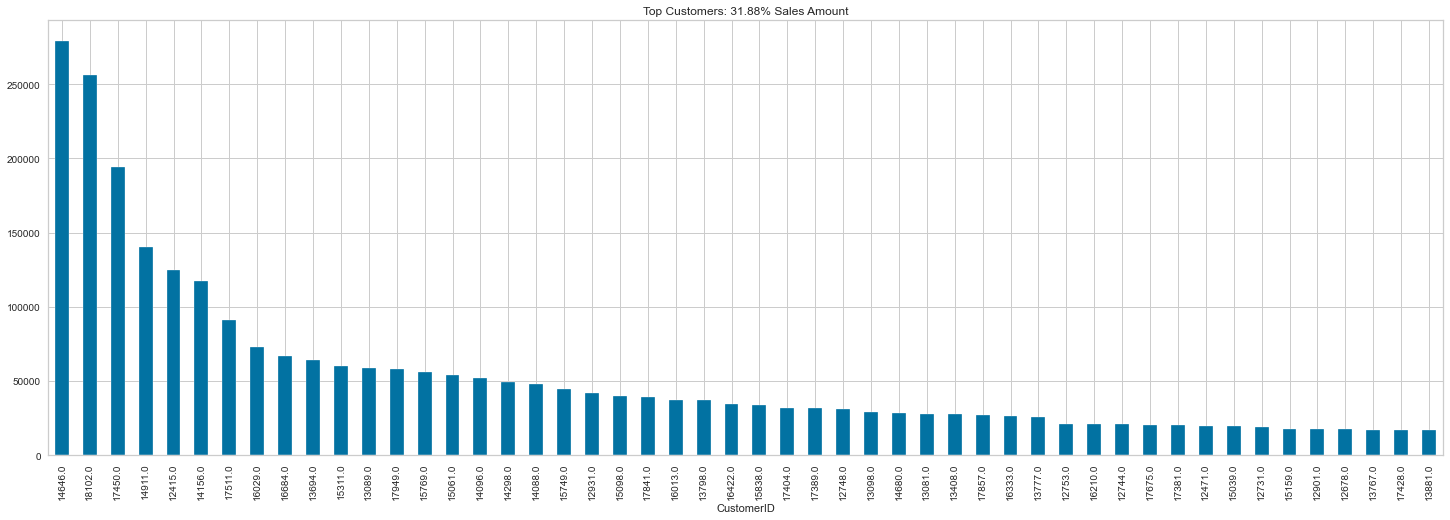

In [38]:
# top 50 customers

fig = plt.figure(figsize=(25, 8))
PercentSales =  np.round((dtnn.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).iloc[:50].\
                          sum()/dtnn.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).\
                          sum()) * 100, 2)
g = dtnn.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).iloc[:50].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

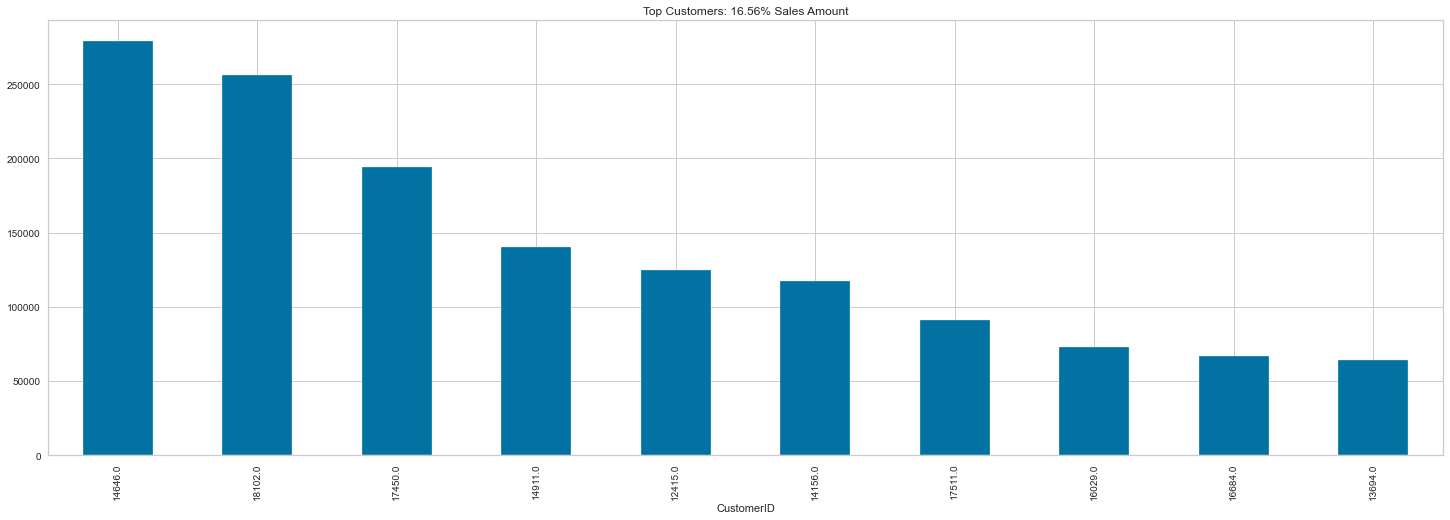

In [39]:
# top 10 customers

fig = plt.figure(figsize=(25, 8))
PercentSales =  np.round((dtnn.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).iloc[:10].\
                          sum()/dtnn.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).\
                          sum()) * 100, 2)
g = dtnn.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False).iloc[:10].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

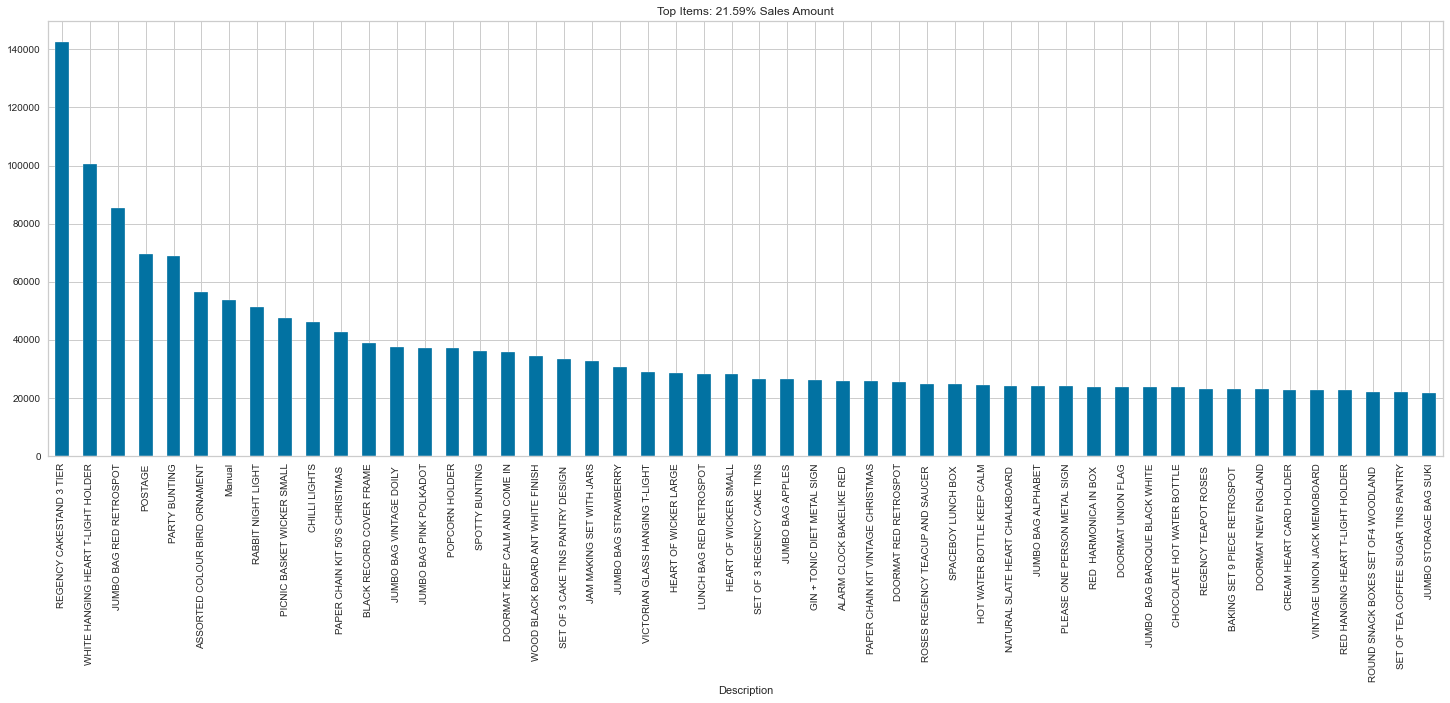

In [40]:
# Top 50 items, most purchased and the percentage of amount of sales they make.

fig = plt.figure(figsize=(25, 8))
PercentSales =  np.round((dtnn.groupby(["Description"]).amount.sum().sort_values(ascending = False).iloc[:50].\
                          sum()/dtnn.groupby(["Description"]).amount.sum().sort_values(ascending = False).\
                          sum()) * 100, 2)
g = dtnn.groupby(["Description"]).amount.sum().sort_values(ascending = False).iloc[:50].\
    plot(kind='bar', title='Top Items: {:3.2f}% Sales Amount'.format(PercentSales))

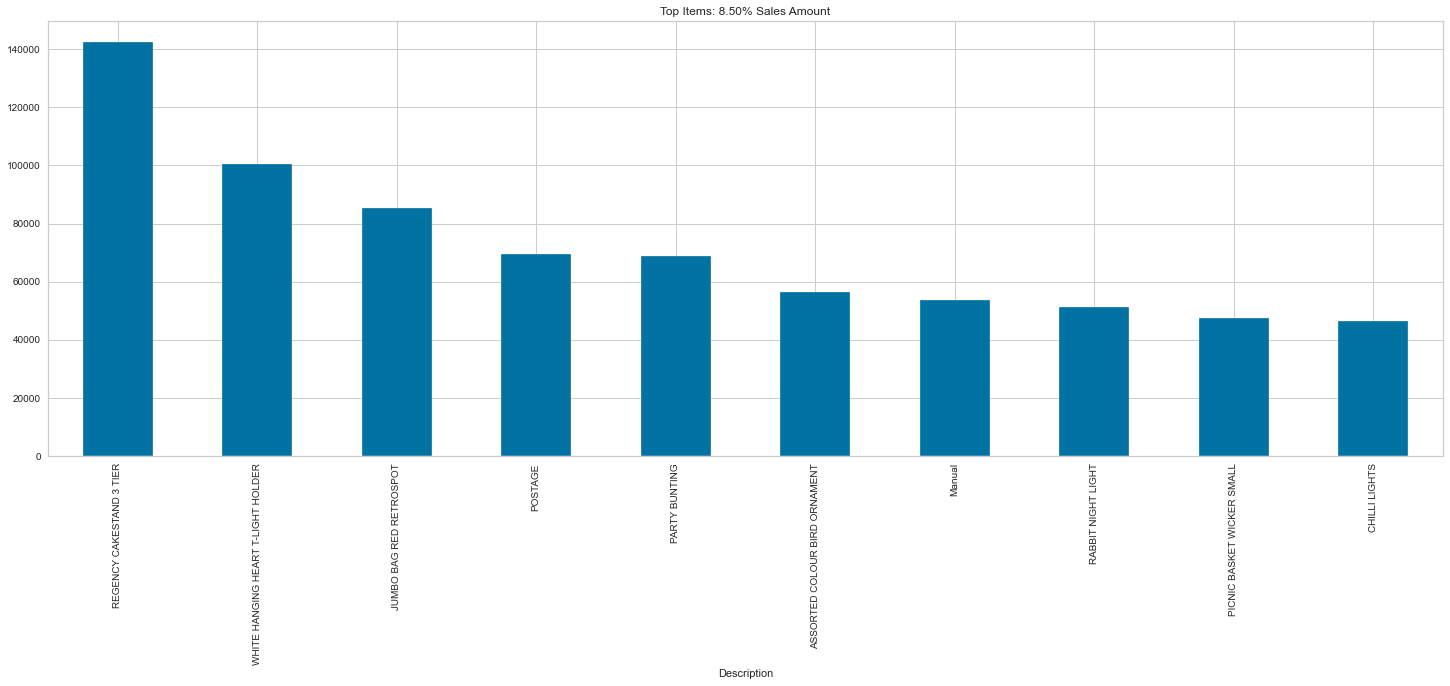

In [41]:
# Top 10 items, most purchased and the percentage of amount of sales they make.

fig = plt.figure(figsize=(25, 8))
PercentSales =  np.round((dtnn.groupby(["Description"]).amount.sum().sort_values(ascending = False).iloc[:10].\
                          sum()/dtnn.groupby(["Description"]).amount.sum().sort_values(ascending = False).\
                          sum()) * 100, 2)
g = dtnn.groupby(["Description"]).amount.sum().sort_values(ascending = False).iloc[:10].\
    plot(kind='bar', title='Top Items: {:3.2f}% Sales Amount'.format(PercentSales))

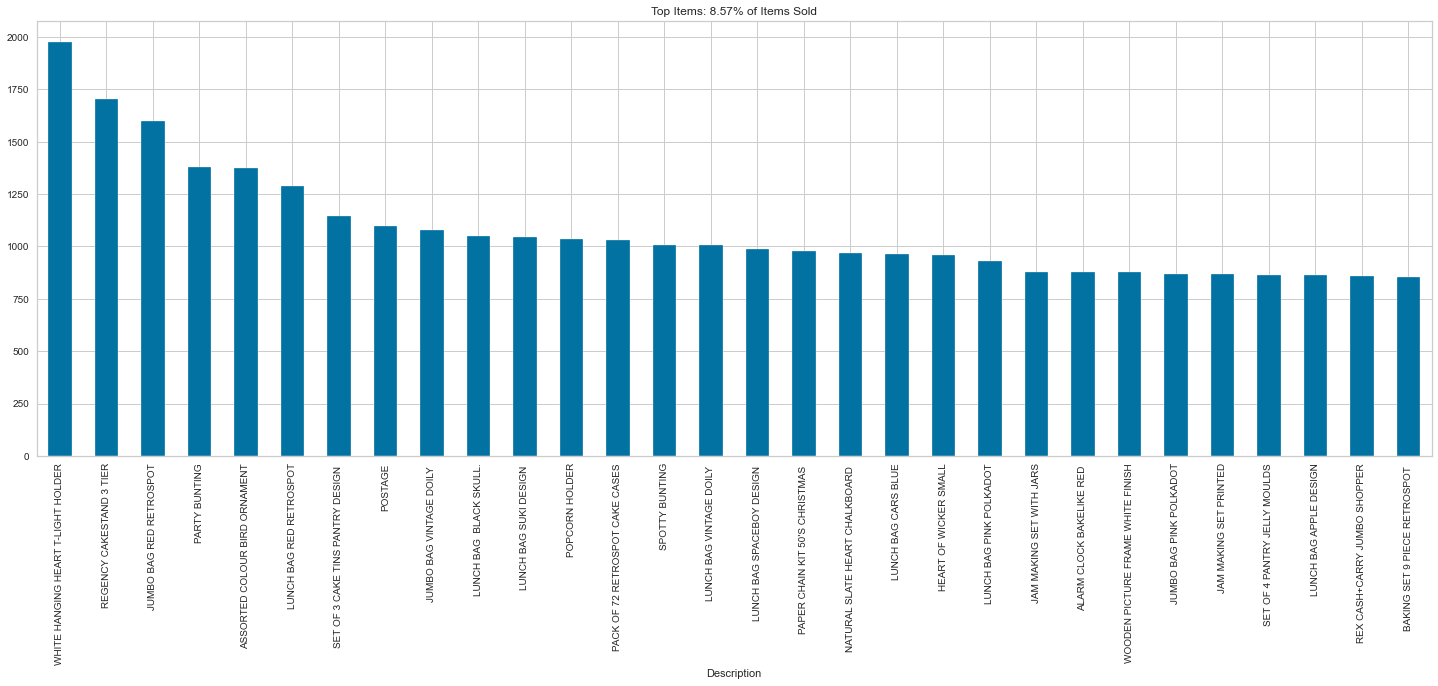

In [42]:
fig = plt.figure(figsize=(25, 8))
PercentSales =  np.round((dtnn[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
                          agg(np.size).sort_values(ascending = False).iloc[:30].\
                          sum()/dtnn[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
                          agg(np.size).sort_values(ascending = False).\
                          sum()) * 100, 2)
g = dtnn[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
agg(np.size).sort_values(ascending = False).iloc[:30].\
    plot(kind='bar', title='Top Items: {:3.2f}% of Items Sold'.format(PercentSales))

In [43]:
# which customers are purchasing what items in bulk

q = '''
select CustomerID, Country, sum(Quantity) as number_of_packets, Description from dtnn
group by customerid, Description
having number_of_packets>5000
order by number_of_packets desc
'''
pysqldf(q)

,CustomerID,Country,number_of_packets,Description
0,17949.0,United Kingdom,11692,POPCORN HOLDER
1,16333.0,United Kingdom,10080,WORLD WAR 2 GLIDERS ASSTD DESIGNS
2,16422.0,United Kingdom,10080,BROCADE RING PURSE
3,16333.0,United Kingdom,8120,RED HARMONICA IN BOX
4,16308.0,United Kingdom,8000,SMALL CHINESE STYLE SCISSOR
5,12901.0,United Kingdom,6768,WORLD WAR 2 GLIDERS ASSTD DESIGNS
6,17306.0,United Kingdom,6624,PACK OF 12 LONDON TISSUES
7,15749.0,United Kingdom,6228,FAIRY CAKE FLANNEL ASSORTED COLOUR
8,18102.0,United Kingdom,5946,CREAM HEART CARD HOLDER
9,14609.0,United Kingdom,5586,ESSENTIAL BALM 3.5g TIN IN ENVELOPE


These customers definitely are wholesalers.

In [44]:
# lets talk more about customers of UK as it is the biggest customer.

dtnn_uk = dtnn[dtnn.Country=='United Kingdom']

In [45]:
# item purchased by most people

q = '''
select Description, count(CustomerID) as number_of_customers, sum(Quantity) as Number_of_pieces from dtnn_uk
group by Description
having number_of_customers>1000
order by number_of_customers desc
'''
pysqldf(q)

,Description,number_of_customers,Number_of_pieces
0,WHITE HANGING HEART T-LIGHT HOLDER,1947,34705
1,JUMBO BAG RED RETROSPOT,1464,41981
2,REGENCY CAKESTAND 3 TIER,1426,9641
3,ASSORTED COLOUR BIRD ORNAMENT,1333,32727
4,PARTY BUNTING,1307,13992
5,LUNCH BAG RED RETROSPOT,1147,13394
6,LUNCH BAG BLACK SKULL.,1049,9904
7,SET OF 3 CAKE TINS PANTRY DESIGN,1020,5253


In [46]:
# most freq customers

q = '''
select CustomerID, count(distinct InvoiceDate) as freq_of_visit, sum(amount) from dtnn_uk
group by CustomerID
having freq_of_visit > 50
order by freq_of_visit desc

'''
pysqldf(q)

,CustomerID,freq_of_visit,sum(amount)
0,12748.0,206,31518.87
1,17841.0,124,38959.30
2,14606.0,94,10795.14
3,13089.0,93,58664.53
4,15311.0,91,60136.15
5,12971.0,82,10938.26
6,16029.0,60,72882.09
7,13408.0,58,27924.44
8,13798.0,57,37096.22
9,18102.0,55,256548.45


In [47]:
# uk customers spending the most

q = '''
select CustomerID, sum(amount) as total_amt, count(distinct invoicedate) as freq from dtnn_uk
group by CustomerID
having total_amt>50000
order by total_amt desc

'''
pysqldf(q)

,CustomerID,total_amt,freq
0,18102.0,256548.45,55
1,17450.0,194203.59,46
2,17511.0,90899.98,32
3,16029.0,72882.09,60
4,16684.0,66653.56,27
5,13694.0,64233.86,50
6,15311.0,60136.15,91
7,13089.0,58664.53,93
8,17949.0,58247.68,45
9,15769.0,56252.72,25


In [48]:
# customers purchasing in bulk

q = '''
select CustomerID, sum(Quantity) as Total_Quantity from dtnn_uk
group by CustomerID
having Total_Quantity>20000
order by Total_Quantity desc

'''
pysqldf(q)

,CustomerID,Total_Quantity
0,17450.0,69833
1,17511.0,64466
2,18102.0,64019
3,13694.0,62770
4,14298.0,56914
5,16684.0,50255
6,16029.0,40207
7,15311.0,37992
8,16422.0,33704
9,16333.0,32184


In [49]:
# Variety items a customer purchases

q = '''
select CustomerID, count(Quantity) Variety from dtnn_uk
group by Description
having Variety >1000
order by count(Quantity) desc

'''
pysqldf(q)

,CustomerID,Variety
0,17850.0,1947
1,16029.0,1464
2,16210.0,1426
3,13047.0,1333
4,14210.0,1307
5,14688.0,1147
6,16218.0,1049
7,13089.0,1020


# Customer segmentation

Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. In business-to-business marketing, a company might segment customers according to a wide range of factors. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

### Why Customer Segmentation?

Segmentation allows marketers to better tailor their marketing efforts to various audience subsets. 

It creates and communicates targeted marketing messages that will resonate with specific groups of customers, but not with others(who will receive messages tailored to their needs and interests, instead). 

Further, can be helpful in selecting the best communication channel for the segment, which might be email, social media posts, 
radio advertising, or another approach, depending on the segment. 

A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.

It helps focus on the most profitable customers and improve customer service.

### How to do Customer Segmentation?

Customer segmentation is all about creating clusters where we only have attributes of customers based on which we have to group them in categories given no prior groupings. Hence comes the unsupervised Machine learning model like clustering. Procedure is to collect as much as data about the customers as attributes, and then creating clusters based on them. Then we can finally find the traits of customer segments by analyzing the characteristics of the clusters.

### How's our data?

The data we have does have some attributes but it quite fails to give enough information about the customer. For the customer segmentation to get to know about the behaviour or purchase pattern of the customer, data must contains some specific attributes, which either are expected to be present in the data or we can form using the existing ones. Those attributes be like how frequently is the customer making purchase. How much they spending, in how many visits. Are they regular or not, or wholesaler or not.
So here we do not have those specific attributes and we need to create and add them to our dataset, namely **Recency**, **Frequency**, **Monetary Value**.

#### Recency

It tells how recent has the customer made a purchase last time, calculated by subtracting the last date of purchase from today's or some specific relevant date.

In [50]:
know_your_data(dtnn)

,data_type,uniques,n_unique,n_null,missing_ration,skewness,kurtosis
Country,object,"[United Kingdom, France, Australia, Netherland...",37,0,0.0,NaN,NaN
CustomerID,float64,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0, ...",4325,0,0.0,0.027083,-1.180695
Description,object,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",2556,0,0.0,NaN,NaN
InvoiceDate,object,"[2010-12-01 08:26:00.000000, 2010-12-01 08:28:...",17209,0,0.0,NaN,NaN
InvoiceNo,int64,"[536365, 536366, 536367, 536368, 536369, 53637...",18446,0,0.0,-0.186743,-1.193334
Quantity,int64,"[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 80...",298,0,0.0,29.684949,1719.124862
StockCode,object,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",2556,0,0.0,NaN,NaN
UnitPrice,float64,"[2.55, 3.39, 2.75, 7.65, 4.25, 1.85, 1.69, 2.1...",398,0,0.0,169.292594,34514.929136
amount,float64,"[15.299999999999999, 20.34, 22.0, 15.3, 25.5, ...",2850,0,0.0,184.480246,70021.967519


In [51]:
dtnn['InvoiceDate'] = dtnn['InvoiceDate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
ref_date = dtnn.InvoiceDate.max() + datetime.timedelta(days=1)
dtnn['days_since_last_purchase'] = (ref_date-dtnn.InvoiceDate).astype('timedelta64[D]')

customer_history = dtnn[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index().\
rename(columns = {'days_since_last_purchase':'Recency'})

In [52]:
customer_history.describe()

,CustomerID,Recency
count,4325.000000,4325.000000
mean,15300.335491,92.175723
std,1721.487572,99.628657
min,12347.000000,1.000000
25%,13814.000000,18.000000
50%,15298.000000,51.000000
75%,16779.000000,141.000000
max,18287.000000,374.000000


It tells how long back the customer had made a purchase. We see half of the customers have last transaction 50 days or less since the very recent trasaction. We can say customers have not made a purchase very recent. 

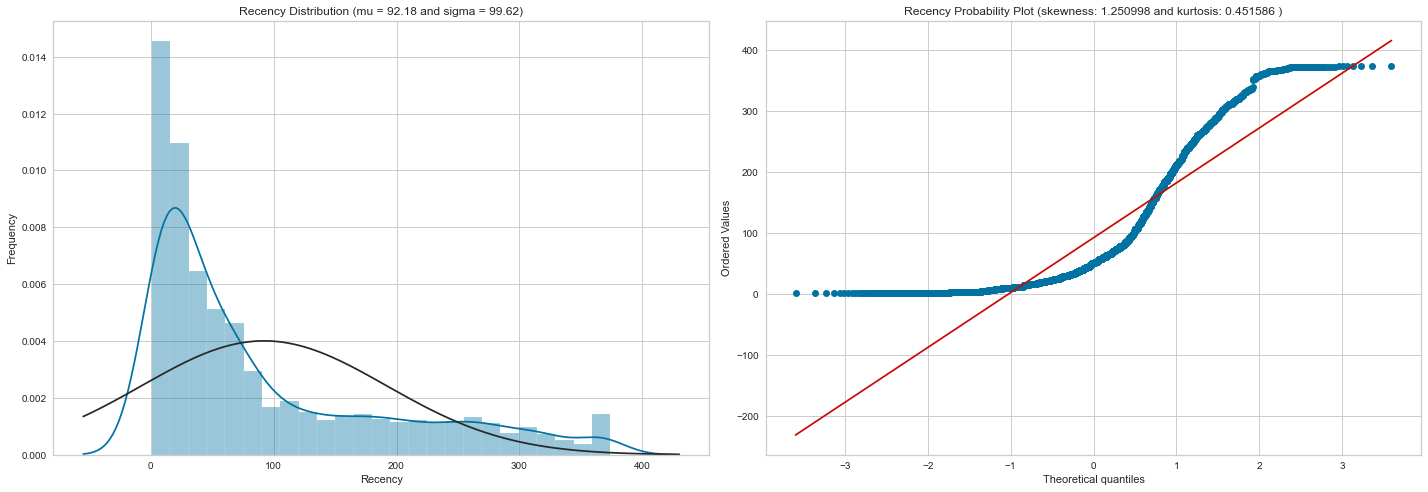

In [53]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution (mu = {:.2f} and sigma = {:.2f})'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history.Recency, 'Recency')

Here we make plots for Recency. The one at left is the distribution plot while on right is QQ plot. 
The distribution plots shows the Recency is skewed right. There are lesser number of people that are not very recent in comparison to the very recent ones. It means if chosen a person randomly, the probabaility that the customer chosen has recently shopped is more. 

Another we have QQ plot which again signifies that the data is skewed and does not follow normal distribution as it does not overlap and no even close to overlap the line passing through the origin.

### Frequency

Next we can have is the Frequency defined as how many times the customer has made transactions. It tells if the customer we have is regular or just comes least often. This particulary filter the customers where the seller can majorly focus with different goals on regular customers and different on least frequent ones. Companies sometimes offer a special card with special offers to their regular customers who shop very often to keep them happy and satisfied with their purchases. 

Here we add Frequency as a column in the customer_history data frame we made earlier.

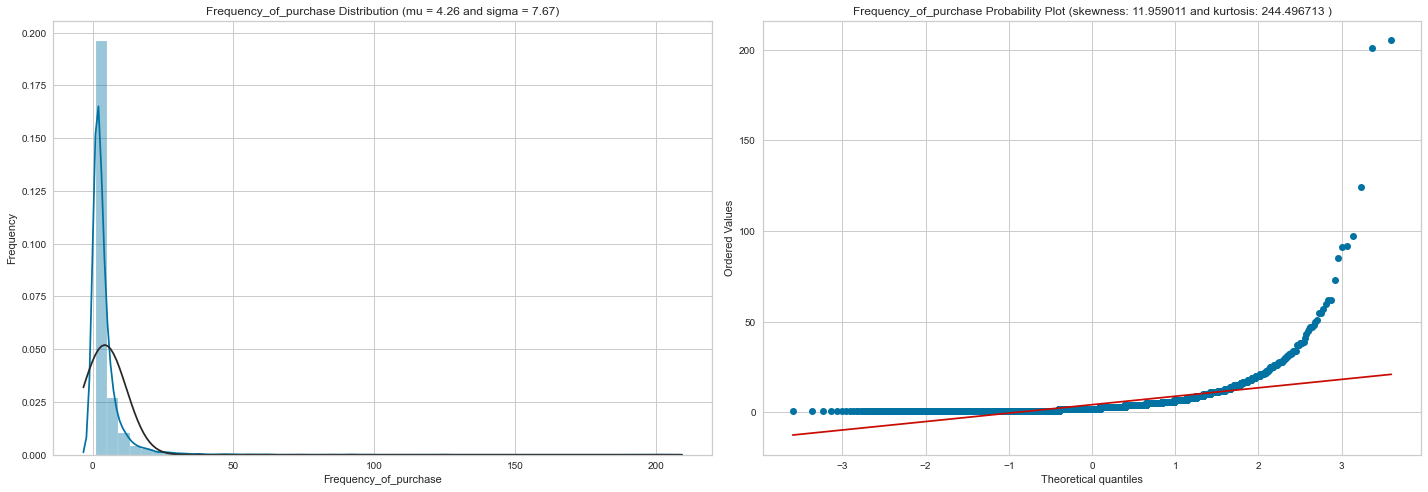

In [54]:
q = '''
select CustomerID, count(distinct InvoiceNo) as Frequency from dtnn
group by CustomerID

'''
customer_freq = pysqldf(q)
customer_history = customer_history.merge(customer_freq)

QQ_plot(customer_history.Frequency, 'Frequency_of_purchase')

Again, we have the distribution plot and QQ plot for Frequency this time. These plots are many times very helpul, be it understanding the distribution of the data, and compare it with normal distribution and also to know the skewness and kurtosis or to see any outliers if present.

We can see Frequency is very skewed and have high kurtosis. The distribution is little close to normal but has many outliers.

### Monetary value

Monetary value as the name, gives the total amount a customer has spent in all their transactions. It tells about the behaviour that the customer is interested in purchasing goods from the company and company can also particularly focus on their demands and interests. 

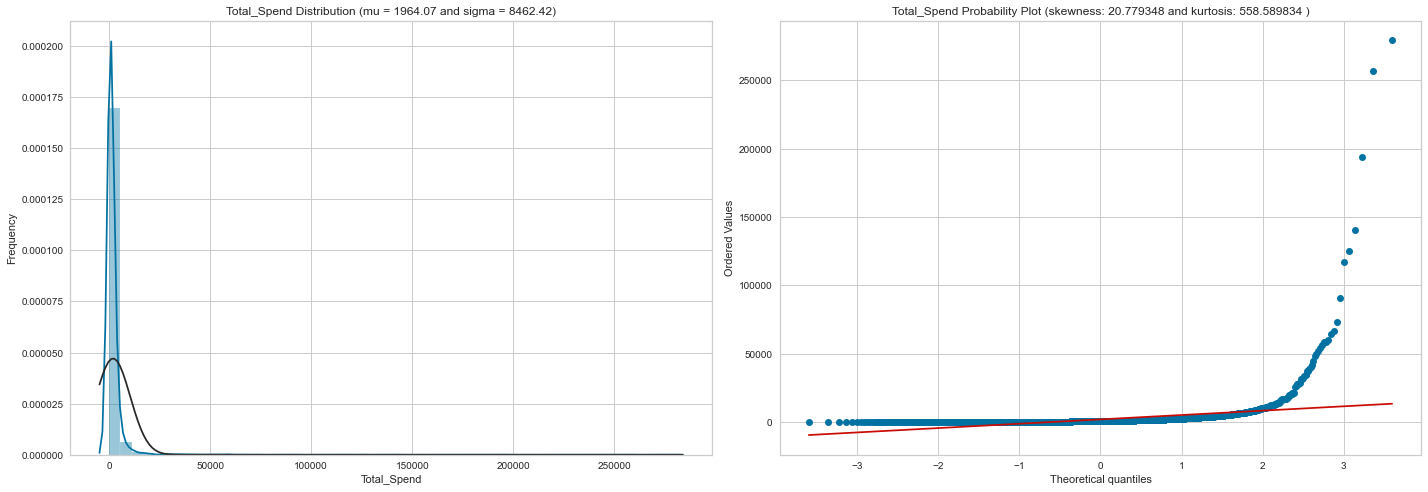

In [55]:
q = '''
select CustomerID, sum(amount) Total_amount from dtnn
group by CustomerID
'''
customer_spend = pysqldf(q)

customer_history = customer_history.merge(customer_spend)
QQ_plot(customer_history.Total_amount, 'Total_Spend')

The distribution plot for the Monetary value is very highly skewed and quite of the kurtosis can also be seen. And yes, we have outliers for sure.

In [56]:
customer_history.describe()

,CustomerID,Recency,Frequency,Total_amount
count,4325.000000,4325.000000,4325.000000,4325.000000
mean,15300.335491,92.175723,4.264971,1964.069757
std,1721.487572,99.628657,7.667892,8463.398741
min,12347.000000,1.000000,1.000000,1.000000
25%,13814.000000,18.000000,1.000000,295.930000
50%,15298.000000,51.000000,2.000000,658.640000
75%,16779.000000,141.000000,5.000000,1633.780000
max,18287.000000,374.000000,205.000000,279052.030000


Let's apply logarithmic transformation on the features we have and then standardize them. The former would try make the features close to normal distribution and the latter will help standardize the values.

In [57]:
customer_history['recency_log'] = customer_history['Recency'].apply(math.log)
customer_history['freq_log'] = customer_history['Frequency'].apply(math.log)
customer_history['amount_log'] = customer_history['Total_amount'].apply(math.log)
ch_subset = customer_history[['recency_log', 'freq_log', 'amount_log']]
scaler = preprocessing.StandardScaler().fit(ch_subset)
ch_scaled = scaler.transform(ch_subset)
pd.DataFrame(ch_scaled, columns = ch_subset.columns).describe()

,recency_log,freq_log,amount_log
count,4.325000e+03,4.325000e+03,4.325000e+03
mean,-1.666488e-17,-4.398537e-17,3.679266e-16
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-2.633238e+00,-1.047586e+00,-5.145471e+00
25%,-6.118910e-01,-1.047586e+00,-6.795505e-01
50%,1.164374e-01,-2.777128e-01,-5.162409e-02
75%,8.276184e-01,7.400038e-01,6.613966e-01
max,1.509820e+00,4.864638e+00,4.695945e+00


In [58]:
customer_history

,CustomerID,Recency,Frequency,Total_amount,recency_log,freq_log,amount_log
0,12347.0,2.0,7,4183.76,0.693147,1.945910,8.338966
1,12348.0,75.0,4,1797.24,4.317488,1.386294,7.494007
2,12349.0,19.0,1,1757.55,2.944439,0.000000,7.471676
3,12350.0,310.0,1,334.40,5.736572,0.000000,5.812338
4,12352.0,36.0,8,2506.04,3.583519,2.079442,7.826459
...,...,...,...,...,...,...,...
4320,18280.0,278.0,1,180.60,5.627621,0.000000,5.196285
4321,18281.0,181.0,1,80.82,5.198497,0.000000,4.392224
4322,18282.0,8.0,2,165.30,2.079442,0.693147,5.107762
4323,18283.0,4.0,16,2082.68,1.386294,2.772589,7.641411


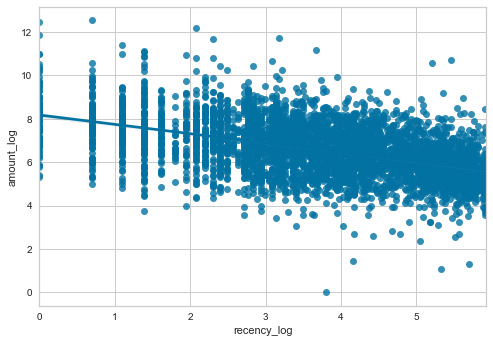

In [59]:
sns.regplot(x="recency_log", y="amount_log", data=customer_history)
plt.show()

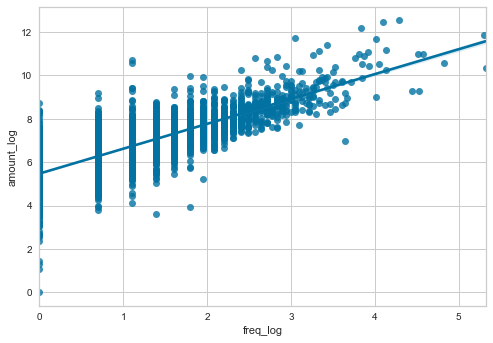

In [60]:
sns.regplot(x="freq_log", y="amount_log", data=customer_history)
plt.show()

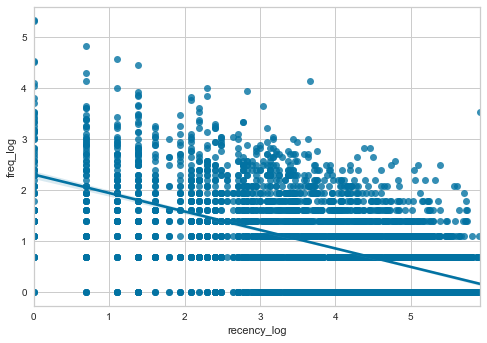

In [61]:
sns.regplot(x="recency_log", y="freq_log", data=customer_history)
plt.show()

Above three graphs are for general idea on how recency, frequency and amount go when taken two at a time. For instance we can see that more frequent customers are likely to spend more. 

### Clustering

Clustering is the unsupervised learning algorith of machine learning which is not used for predicting but for making seperate groups that too which are not already defined or known. Here, we would be using K-means Clustering algorithm which starts by placing the centroids randomly followed by assigning each instance to the closest centroid leading to the formation of clusters.

In [62]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(ch_scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

### Elbow method

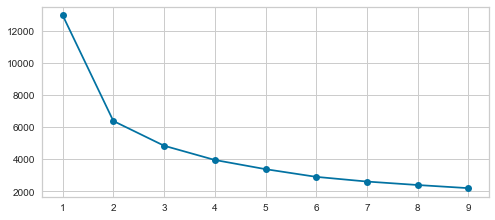

In [63]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")

plt.show()

In [64]:
silhouette_scores = [silhouette_score(ch_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

In [65]:
silhouette_scores

[0.43108130341780027,
 0.3378215792723048,
 0.3348492952494377,
 0.3026345879514504,
 0.30952163430589075,
 0.30745207812973036,
 0.2782776836458694,
 0.28016492191456555]

### Silhoutte scores method

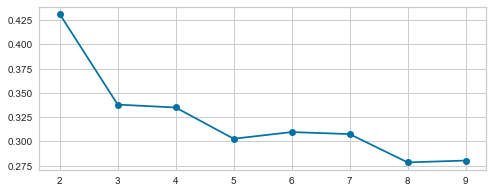

In [66]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.show()

For n_clusters = 4 The average silhouette_score is : 0.33478430501190426


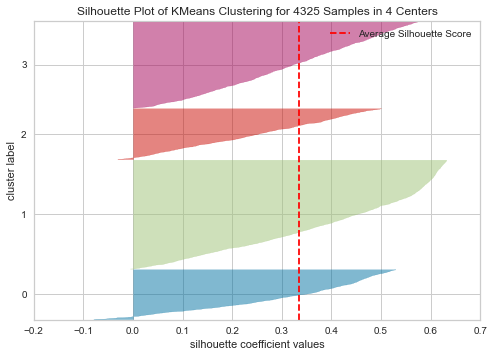

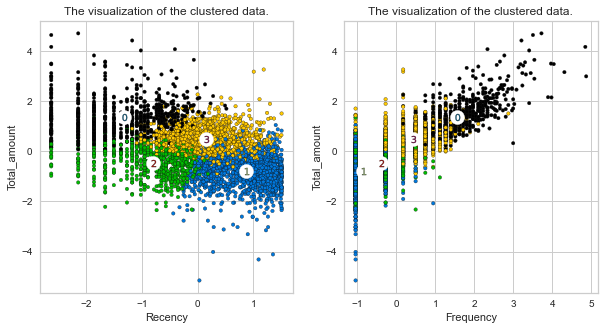

For n_clusters = 6 The average silhouette_score is : 0.3092331731581575


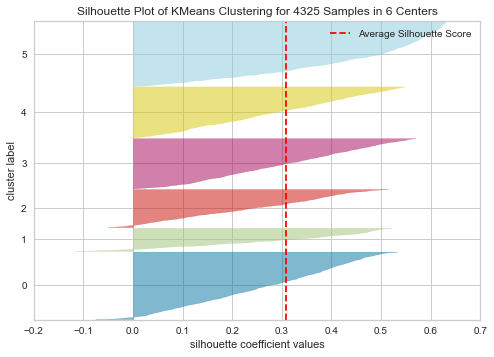

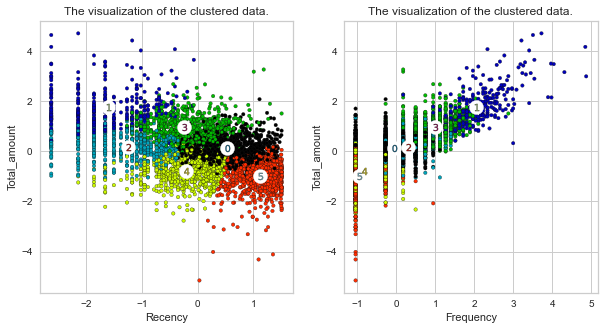

For n_clusters = 7 The average silhouette_score is : 0.30802810233991973


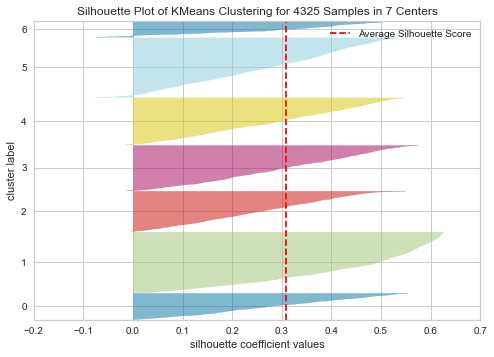

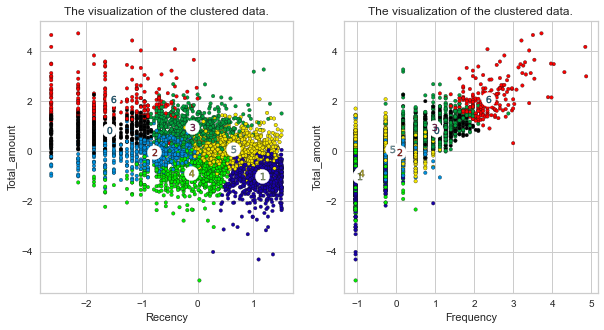

In [67]:
n_clusters = [4,6,7]
X = ch_scaled
centers_list = []
clusterer_list = []

for n in n_clusters:
    clusterer = KMeans(n, random_state = 10)
    cluster_labels = clusterer.fit_predict(X)
    clusterer_list.append(clusterer)
    centers_list.append(clusterer.cluster_centers_)
    visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score is :", silhouette_avg)
    
    
    visualizer.fit(X)
    visualizer.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(x=X[:,0], y=X[:,2], c=cm.nipy_spectral(cluster_labels/n), marker='.', edgecolor='k')
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(centers[:, 0], centers[:, 2], marker='o', c="white", s=200)
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[2], marker='$%d$' % i, s=50, edgecolor='k')
        
    plt.title("The visualization of the clustered data.")
    plt.xlabel("Recency")
    plt.ylabel("Total_amount")
    
    
    plt.subplot(1,2,2)
    plt.scatter(x=X[:,1], y=X[:,2], c=cm.nipy_spectral(cluster_labels/n), marker='.', edgecolor='k')
    plt.scatter(centers[:, 1], centers[:, 2], marker='o', c="white", s=200)
    for i, c in enumerate(centers):
        plt.scatter(c[1], c[2], marker='$%d$' % i, s=50, edgecolor='k')
        
    plt.title("The visualization of the clustered data.")
    plt.xlabel("Frequency")
    plt.ylabel("Total_amount")
    
    
    plt.show()

What we say?

4-clusters:
Here we have the 2nd cluster from 3-clusters been clustered into two sub-clusters for better segmentation.
cluster 1 and 2 are least frequent and somewhere spend close, but 1 is less recent than 2, hence customers in cluster 1 need to be motivated to shop, be it promotion or discount. 

6-clusters:
Clusters 4 and 5, and 0 and 2 have silimar spend and frequency of visits, where 5 and 0 are less recent than 4 and 2 respectively. Hence 5 and 0 need to be motivated to purchase more. 
Cluster 1 spends good and is frequent too, and has shopped most recent. Hence the best customers category.

7-clusters:
Not much, but segmentation has improved from 6 clusters.
The pairs of clusters, (1,4), (2,5) and (0,3) are very similar in amount spend and frequency of visits.
But what makes them categorize is when did they last visited.
The clusters 1, 5 and 3 has not shopped for long but they are likely to shop more.
Clusters 0 and 6 are very similar in recency, but 6 is more frequent and spends more. Hence cluster 0 can be motivated to shop more.

In [68]:
for i in n_clusters:
    print('For {} clusters, Centers of each cluster:'.format(i))
    print(pd.DataFrame(np.exp(scaler.inverse_transform(centers_list[n_clusters.index(i)])),
                       columns=['Recency', 'Frequency', 'Total_amount']))
    print('-'*40)

For 4 clusters, Centers of each cluster:
      Recency  Frequency  Total_amount
0    6.550554  10.287841   3967.678488
1  147.903757   1.190099    253.834448
2   13.546579   1.810992    396.526016
3   53.666965   3.747366   1319.839437
----------------------------------------
For 6 clusters, Centers of each cluster:
      Recency  Frequency  Total_amount
0   92.489686   2.406372    823.111225
1    4.287256  15.988604   6645.516000
2    7.132329   3.378987    894.766560
3   30.517013   6.213231   2413.612131
4   31.648319   1.220512    252.954914
5  215.934819   1.092288    197.072697
----------------------------------------
For 7 clusters, Centers of each cluster:
      Recency  Frequency  Total_amount
0    4.383946   6.433332   2080.983778
1  224.178111   1.083506    196.612966
2   13.844837   2.696540    664.034337
3   37.029129   6.110754   2410.612827
4   36.219085   1.137587    230.464208
5  107.639096   2.306580    803.297551
6    4.841116  21.090455  10007.215614
---------------

In [69]:
customer_history['clusters_4'] = clusterer_list[n_clusters.index(4)].predict(ch_scaled)
customer_history['clusters_6'] = clusterer_list[n_clusters.index(6)].predict(ch_scaled)
customer_history['clusters_7'] = clusterer_list[n_clusters.index(7)].predict(ch_scaled)

customer_history

,CustomerID,Recency,Frequency,Total_amount,recency_log,freq_log,amount_log,clusters_4,clusters_6,clusters_7
0,12347.0,2.0,7,4183.76,0.693147,1.945910,8.338966,0,1,0
1,12348.0,75.0,4,1797.24,4.317488,1.386294,7.494007,3,3,3
2,12349.0,19.0,1,1757.55,2.944439,0.000000,7.471676,2,4,2
3,12350.0,310.0,1,334.40,5.736572,0.000000,5.812338,1,5,1
4,12352.0,36.0,8,2506.04,3.583519,2.079442,7.826459,3,3,3
...,...,...,...,...,...,...,...,...,...,...
4320,18280.0,278.0,1,180.60,5.627621,0.000000,5.196285,1,5,1
4321,18281.0,181.0,1,80.82,5.198497,0.000000,4.392224,1,5,1
4322,18282.0,8.0,2,165.30,2.079442,0.693147,5.107762,2,4,2
4323,18283.0,4.0,16,2082.68,1.386294,2.772589,7.641411,0,1,0


In [70]:
customer_history['clusters_4'] = customer_history.clusters_4.apply(str)
customer_history['clusters_6'] = customer_history.clusters_6.apply(str)
customer_history['clusters_7'] = customer_history.clusters_7.apply(str)

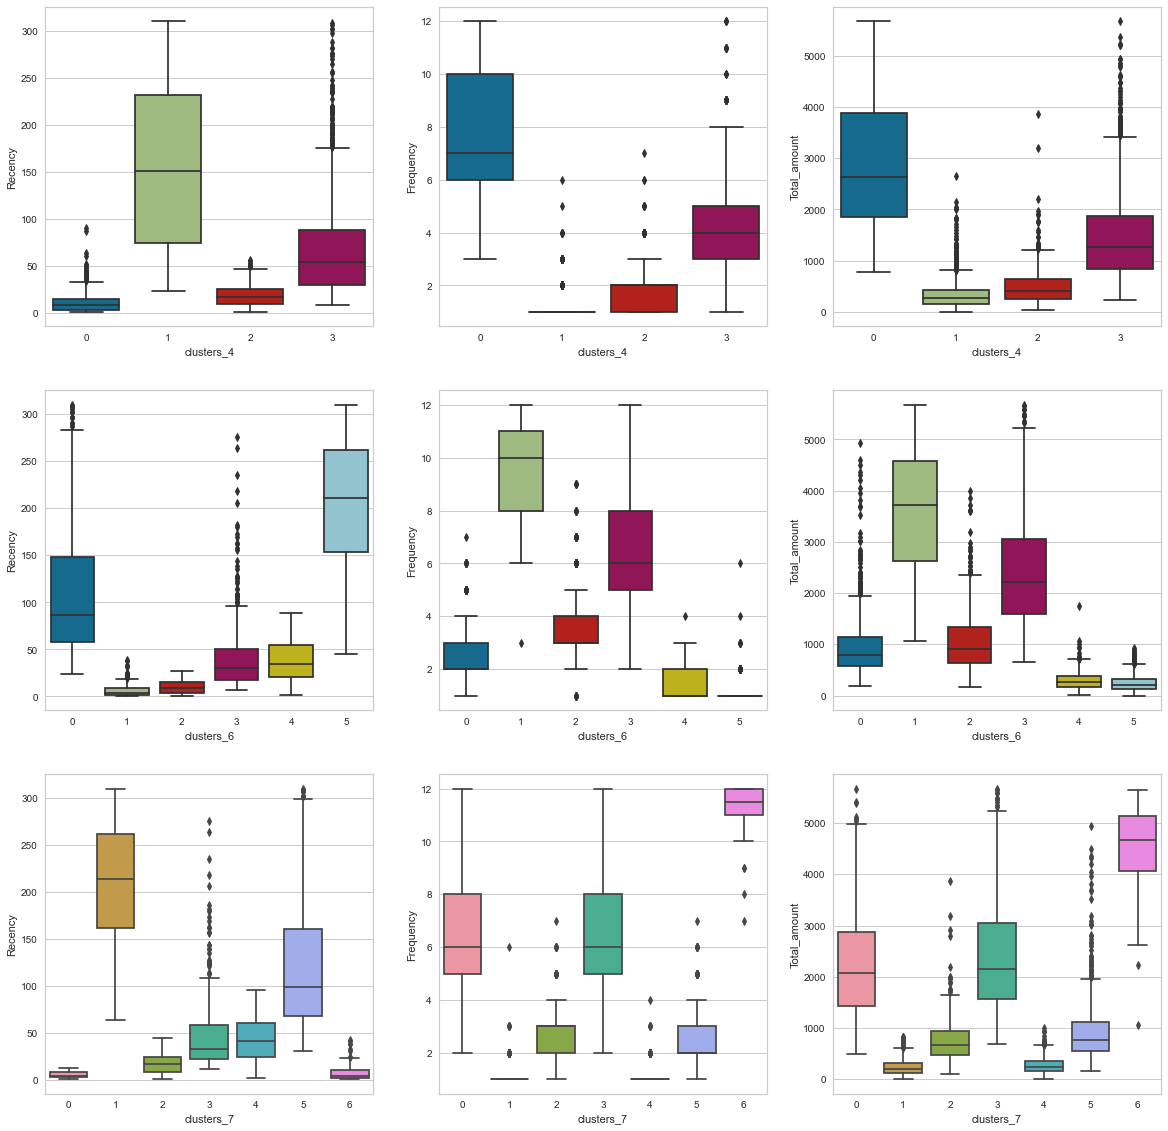

In [71]:
features = ['Recency', 'Frequency', 'Total_amount']
cut_off_quantile = 95
figure, axes = plt.subplots(3, 3, figsize = (20, 20))
j=0
for n in n_clusters:
    clstr = 'clusters_'+str(n)
    order=sorted(list(customer_history[clstr].unique()))
    for i in range(len(features)):
        y0 = customer_history[[features[i],clstr]][customer_history[features[i]]<np.percentile(customer_history[features[i]],cut_off_quantile)]
        sns.boxplot(ax=axes[j, i], data = y0, x=clstr, y=features[i], order = order)
    j+=1

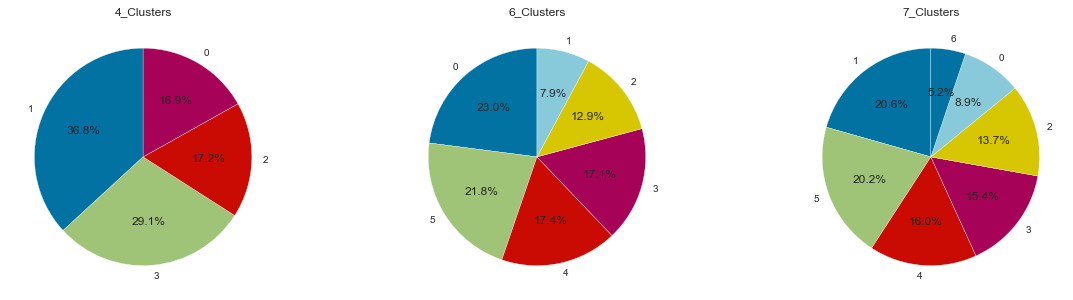

In [72]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
market = customer_history.clusters_4.value_counts()
g = plt.pie(x=market, labels=market.index, startangle=90, autopct='%1.1f%%')
plt.title('4_Clusters')
plt.subplot(1,3,2)
market = customer_history.clusters_6.value_counts()
g = plt.pie(x=market, labels=market.index, startangle=90, autopct='%1.1f%%')
plt.title('6_Clusters')
plt.subplot(1,3,3)
market = customer_history.clusters_7.value_counts()
g = plt.pie(x=market, labels=market.index, startangle=90, autopct='%1.1f%%')
plt.title('7_Clusters')
plt.show()

Having look at clusters and the pie chart we can see the size of a particular segment.
We observe that the 6th cluster in 7-clusters which consist of our best customers is too small. Work needs to be done to make more customers shift to this cluster for higher and stable profits.
The cluster 1 in the 7-clusters make the biggest segment. They are least profitable. We are at the verge of losing them. Better we collect more information about them and work accordingly. They are similar to cluster 4 in their spend and frequency of visits.

More data should be collected and more categories need to be made to make the analysis better. 

Like, how much a customer is spending in each of their visit to know if they are shopping a huge lot or just visiting for a few selected items. 
Apart from how recent they shopped, we can try make an attribute for how long they have been shopping.  
How frequent are they shopping in a particular time period, to know if they are motivated to discounts or promotions?